<a href="https://colab.research.google.com/github/aboagyeso/MLP-FFNN/blob/master/Copy_of_Kinase_Regression_P00533.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT PACKAGES

In [1]:
import numpy as np
import sklearn.metrics, math
from sklearn.linear_model import LinearRegression  
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
# Set random seed
np.random.seed(0)

Using TensorFlow backend.


In [0]:

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
#from xgboost import XGBRegressor

DEFINE CUSTOM FUNCTIONS

In [0]:


# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [0]:

def add_gausian(y,mu,sigma):
    noise = np.random.normal(mu,sigma,[4175, 117])
    df_aug = df_train_set +noise 
    #df_new = pd.concat([df_train_set,df_aug])
    return(df_aug)

def drop_corr(df):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column]>0.95)]
    df_new = df.drop(df[to_drop],axis = 1)
    return(df_new)

def model_eval(model):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    #model_score = model.score(X_test,y_test)
    model_mse =  mse(y_test,pred)
    model_r2 =r2(y_test,pred)
    return(-model_mse, model_r2)

In [0]:
# Load libraries
from keras import models
from keras import layers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

READ IN THE DATAFRAME AND CHECK OUTPUT

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/aboagyeso/Kinase_activity/master/data/kinase_files/KinaseP00533.csv')
df.head()

,Unnamed: 0,target_id,pAc,smiles,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumHeavyAtoms,NumAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,Chi0v,Chi1v,Chi2v,Chi3v,Chi4v,Chi1n,Chi2n,Chi3n,...,MQN2,MQN3,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN12,MQN13,MQN14,MQN15,MQN16,MQN17,MQN19,MQN20,MQN21,MQN22,MQN23,MQN24,MQN25,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,2609,P00533,1.60,C1=CC(=CC=C1CCC(=O)C2=C(C=C(C=C2O)O)O)O,2.3245,72.1947,114.921781,97.99,274.272,274.084124,5,4,4,4,5,0,5,20,34,0,0,2,2,0,0,0,0,0,2,0,0,0.133333,10.575418,6.031726,4.448645,2.937401,1.928546,6.031726,4.448645,2.937401,...,0,0,0,0,0,0,0,0,5,0,20,8,1,0,6,6,4,10,5,4,4,0,0,5,2,1,0,6,6,0,0,0,0,2,0,0,0,0,0,0
1,2610,P00533,1.72,C1=CC(=C(C=C1/C=C/C(=O)C2=C(C(=C(C=C2)O[C@H]3[...,-0.4162,107.3029,180.820025,197.37,450.396,450.116212,11,8,6,8,11,0,11,32,54,5,0,3,2,1,1,0,1,1,2,0,0,0.285714,16.437764,9.401589,7.069336,4.897849,3.050766,9.401589,7.069336,4.897849,...,0,0,0,0,0,0,0,0,10,1,32,14,2,0,12,6,6,22,11,8,8,0,0,9,4,1,0,6,12,0,0,0,0,3,0,0,0,0,0,0
2,2611,P00533,1.96,C[C@@H](C(=O)N1CCN(CC1)C2=CC(=C(C=C2NC(=O)C=C)...,3.3508,156.8052,240.763560,137.22,577.045,576.200029,12,3,8,3,10,2,13,41,70,1,0,5,4,1,1,3,1,1,1,0,0,0.250000,23.298170,13.260590,9.762369,6.999277,4.859648,12.882625,9.355169,6.722681,...,0,1,0,0,0,0,2,6,4,0,41,14,3,0,17,11,8,16,12,3,3,0,0,7,4,3,0,15,12,0,0,0,1,4,0,0,0,0,2,1
3,2612,P00533,1.99,COC1=C(C=C(C(=C1)N2CCN(CC2)C(=O)N3CCNCC3)NC(=O...,3.4686,169.9561,259.003075,132.26,617.114,616.242563,13,3,7,3,10,3,14,44,77,0,0,6,4,2,2,3,2,2,1,0,0,0.300000,25.049247,14.699534,10.767781,7.988250,5.622447,14.321570,10.360580,7.711653,...,0,1,0,0,0,0,2,8,3,0,44,12,3,0,23,11,7,16,13,3,3,0,0,5,4,2,0,20,13,0,0,0,1,5,0,0,0,0,2,1
4,2613,P00533,2.00,CN(C)CC(=O)N1CCN(CC1)C2=CC(=C(C=C2NC(=O)C=C)NC...,3.5316,163.6784,248.094102,120.23,590.088,589.231664,12,2,9,2,10,2,13,42,74,0,0,5,4,1,1,3,1,1,1,0,0,0.275862,24.427927,13.700574,10.379680,7.134408,4.994960,13.322609,9.972480,6.857811,...,0,1,0,0,0,0,3,6,3,0,42,15,3,0,17,11,9,15,12,2,2,0,0,7,5,3,0,15,12,0,0,0,1,4,0,0,0,0,2,1


In [7]:
#Check the shape of the dataframe
df.shape

(4639, 120)

In [8]:
#Drop the highly correlated features
drop_corr(df).head()

,Unnamed: 0,target_id,smiles,SlogP,SMR,TPSA,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,HallKierAlpha,slogp_VSA1,slogp_VSA2,slogp_VSA3,slogp_VSA4,slogp_VSA5,slogp_VSA6,slogp_VSA7,slogp_VSA8,slogp_VSA10,slogp_VSA11,slogp_VSA12,smr_VSA1,smr_VSA2,...,peoe_VSA7,peoe_VSA8,peoe_VSA9,peoe_VSA10,peoe_VSA11,peoe_VSA12,peoe_VSA13,peoe_VSA14,MQN2,MQN3,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN13,MQN14,MQN15,MQN16,MQN20,MQN24,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41
0,2609,P00533,C1=CC(=CC=C1CCC(=O)C2=C(C=C(C=C2O)O)O)O,2.3245,72.1947,97.99,5,4,4,4,5,0,5,0,0,2,2,0,0,0,0,0,2,0,0,0.133333,-2.69,0.000000,26.209355,6.420822,0.0,22.342262,36.398202,0.000000,0.00000,0.000000,22.998047,0.00000,25.220647,0.0,...,24.117007,18.553556,0.000000,28.561499,5.783245,0.000000,0.00000,0.000000,0,0,0,0,0,0,0,0,5,0,8,1,0,6,10,0,5,2,1,0,6,6,0,0,0,0,2,0,0,0,0,0
1,2610,P00533,C1=CC(=C(C=C1/C=C/C(=O)C2=C(C(=C(C=C2)O[C@H]3[...,-0.4162,107.3029,197.37,11,8,6,8,11,0,11,5,0,3,2,1,1,0,1,1,2,0,0,0.285714,-3.35,4.736863,83.948238,4.736863,0.0,15.921440,36.407855,0.000000,6.07602,0.000000,28.747559,0.00000,55.120482,0.0,...,35.904940,0.000000,12.170333,24.415866,28.781292,12.039539,0.00000,0.000000,0,0,0,0,0,0,0,0,10,1,14,2,0,12,22,0,9,4,1,0,6,12,0,0,0,0,3,0,0,0,0,0
2,2611,P00533,C[C@@H](C(=O)N1CCN(CC1)C2=CC(=C(C=C2NC(=O)C=C)...,3.3508,156.8052,137.22,12,3,8,3,10,2,13,1,0,5,4,1,1,3,1,1,1,0,0,0.250000,-4.68,20.270350,80.795623,9.589074,0.0,6.923737,61.577322,5.022633,16.77408,23.010498,5.749512,11.60094,19.432465,0.0,...,31.198859,44.005688,52.798906,11.853478,0.000000,11.855519,5.90718,0.000000,0,1,0,0,0,0,2,6,4,0,14,3,0,17,16,0,7,4,3,0,15,12,0,0,0,1,4,0,0,0,0,2
3,2612,P00533,COC1=C(C=C(C(=C1)N2CCN(CC2)C(=O)N3CCNCC3)NC(=O...,3.4686,169.9561,132.26,13,3,7,3,10,3,14,0,0,6,4,2,2,3,2,2,1,0,0,0.300000,-4.88,25.587138,100.787999,4.794537,0.0,0.000000,61.577322,5.022633,16.77408,27.805035,5.749512,11.60094,14.325937,0.0,...,24.275121,70.184713,52.798906,5.749512,0.000000,11.855519,0.00000,6.031115,0,1,0,0,0,0,2,8,3,0,12,3,0,23,16,0,5,4,2,0,20,13,0,0,0,1,5,0,0,0,0,2
4,2613,P00533,CN(C)CC(=O)N1CCN(CC1)C2=CC(=C(C=C2NC(=O)C=C)NC...,3.5316,163.6784,120.23,12,2,9,2,10,2,13,0,0,5,4,1,1,3,1,1,1,0,0,0.275862,-4.68,20.270350,95.125139,9.589074,0.0,0.000000,61.577322,5.022633,16.77408,23.010498,5.749512,11.60094,14.325937,0.0,...,38.370465,44.005688,59.343662,5.749512,0.000000,17.762699,0.00000,0.000000,0,1,0,0,0,0,3,6,3,0,15,3,0,17,15,0,7,5,3,0,15,12,0,0,0,1,4,0,0,0,0,2


In [9]:
drop_corr(df).shape

(4639, 93)

In [0]:
#Plot distribution of the pAc with the density estimation function
#f, ax = plt.subplots(figsize=(6, 6))
#sns.distplot(df.pAc,color = 'green');
#sns.set_style("whitegrid")

In [0]:
#Boxplot of pAc,It has a few outliers but the distribution in fairly normal
#f, ax = plt.subplots(figsize=(5, 6))
#sns.set_style("whitegrid")
#data = df.pAc
#sns.boxplot(data=data);

In [12]:
#Drop unwanted columns
df = df.drop(['Unnamed: 0','smiles','target_id'], axis=1)
df.head()

,pAc,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumHeavyAtoms,NumAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,Chi0v,Chi1v,Chi2v,Chi3v,Chi4v,Chi1n,Chi2n,Chi3n,Chi4n,HallKierAlpha,kappa1,...,MQN2,MQN3,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN12,MQN13,MQN14,MQN15,MQN16,MQN17,MQN19,MQN20,MQN21,MQN22,MQN23,MQN24,MQN25,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,1.60,2.3245,72.1947,114.921781,97.99,274.272,274.084124,5,4,4,4,5,0,5,20,34,0,0,2,2,0,0,0,0,0,2,0,0,0.133333,10.575418,6.031726,4.448645,2.937401,1.928546,6.031726,4.448645,2.937401,1.928546,-2.69,13.734989,...,0,0,0,0,0,0,0,0,5,0,20,8,1,0,6,6,4,10,5,4,4,0,0,5,2,1,0,6,6,0,0,0,0,2,0,0,0,0,0,0
1,1.72,-0.4162,107.3029,180.820025,197.37,450.396,450.116212,11,8,6,8,11,0,11,32,54,5,0,3,2,1,1,0,1,1,2,0,0,0.285714,16.437764,9.401589,7.069336,4.897849,3.050766,9.401589,7.069336,4.897849,3.050766,-3.35,23.315994,...,0,0,0,0,0,0,0,0,10,1,32,14,2,0,12,6,6,22,11,8,8,0,0,9,4,1,0,6,12,0,0,0,0,3,0,0,0,0,0,0
2,1.96,3.3508,156.8052,240.763560,137.22,577.045,576.200029,12,3,8,3,10,2,13,41,70,1,0,5,4,1,1,3,1,1,1,0,0,0.250000,23.298170,13.260590,9.762369,6.999277,4.859648,12.882625,9.355169,6.722681,4.666795,-4.68,27.870591,...,0,1,0,0,0,0,2,6,4,0,41,14,3,0,17,11,8,16,12,3,3,0,0,7,4,3,0,15,12,0,0,0,1,4,0,0,0,0,2,1
3,1.99,3.4686,169.9561,259.003075,132.26,617.114,616.242563,13,3,7,3,10,3,14,44,77,0,0,6,4,2,2,3,2,2,1,0,0,0.300000,25.049247,14.699534,10.767781,7.988250,5.622447,14.321570,10.360580,7.711653,5.429594,-4.88,29.203414,...,0,1,0,0,0,0,2,8,3,0,44,12,3,0,23,11,7,16,13,3,3,0,0,5,4,2,0,20,13,0,0,0,1,5,0,0,0,0,2,1
4,2.00,3.5316,163.6784,248.094102,120.23,590.088,589.231664,12,2,9,2,10,2,13,42,74,0,0,5,4,1,1,3,1,1,1,0,0,0.275862,24.427927,13.700574,10.379680,7.134408,4.994960,13.322609,9.972480,6.857811,4.802107,-4.68,28.834518,...,0,1,0,0,0,0,3,6,3,0,42,15,3,0,17,11,9,15,12,2,2,0,0,7,5,3,0,15,12,0,0,0,1,4,0,0,0,0,2,1


In [0]:
# Get the feature vector
X = df.drop(columns=['pAc'],axis=1)
# Get the target vector
y = df["pAc"]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

In [15]:
#Check the shape of the training and testing data 
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((4175, 116), (464, 116), (4175,), (464,))

 Add the X_train and y_train to form a a training set for augmentation
 **bold text**

In [16]:
df_train_set = pd.concat([X_train, y_train], axis = 1)
df_train_set.head()

,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumHeavyAtoms,NumAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,Chi0v,Chi1v,Chi2v,Chi3v,Chi4v,Chi1n,Chi2n,Chi3n,Chi4n,HallKierAlpha,kappa1,kappa2,...,MQN3,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN12,MQN13,MQN14,MQN15,MQN16,MQN17,MQN19,MQN20,MQN21,MQN22,MQN23,MQN24,MQN25,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42,pAc
1554,3.17066,132.7596,216.243613,186.70,606.227,603.959308,10,6,8,6,8,2,12,35,53,0,0,2,2,0,0,0,0,0,2,0,0,0.130435,21.013122,11.385058,8.654581,5.617040,3.624629,9.799062,6.945907,4.408064,2.689725,-4.00,27.246094,12.459259,...,0,2,0,0,0,4,0,6,0,35,18,4,2,6,6,8,16,10,6,6,0,0,10,9,4,0,4,8,0,0,0,0,2,0,0,0,0,0,0,5.673333
1736,1.91430,75.2432,112.539630,118.53,275.703,275.068621,7,6,2,4,6,0,8,19,29,0,0,3,3,0,0,2,0,0,1,0,0,0.000000,10.439636,5.807305,4.336043,2.787859,1.960108,5.429340,3.899607,2.552762,1.769820,-2.54,11.544773,4.286916,...,1,0,0,0,0,3,4,0,0,19,5,0,0,8,8,2,7,7,6,4,0,0,3,1,0,0,8,7,0,0,0,1,2,0,0,0,0,2,1,5.855000
4285,5.42252,140.0044,219.072779,79.38,528.003,527.189959,7,2,10,2,6,1,10,37,65,0,0,4,3,1,1,1,1,1,2,0,0,0.296296,21.193860,12.397987,9.114282,6.256732,4.221842,12.020023,8.707081,5.961362,3.986745,-3.56,26.501547,12.603633,...,1,0,0,0,0,2,3,2,0,37,15,2,0,14,9,10,9,7,2,2,0,0,5,7,2,0,14,9,0,0,0,1,3,0,0,0,0,0,0,8.520000
149,3.51302,95.5944,138.917663,82.51,318.384,318.159295,6,2,2,1,6,0,6,24,42,0,0,4,4,0,0,3,0,0,1,0,0,0.222222,13.854870,7.908331,6.204554,4.109138,2.932297,7.908331,6.204554,4.109138,2.932297,-3.02,14.564584,5.263251,...,0,0,0,0,0,1,5,0,0,24,6,0,0,11,10,2,6,6,2,1,0,0,4,0,1,0,10,9,0,0,0,1,3,0,0,0,0,4,2,4.000000
4609,4.45480,117.2004,178.767480,79.38,431.899,431.152431,7,2,8,2,6,1,9,30,53,0,0,3,3,0,0,1,0,0,2,0,0,0.285714,17.755417,9.830513,7.283345,4.568669,2.985126,9.452549,6.876145,4.279023,2.804584,-2.97,21.732031,9.687079,...,1,0,0,0,0,3,2,2,0,30,14,1,0,9,8,8,9,7,2,2,0,0,6,6,2,0,8,8,0,0,0,0,3,0,0,0,0,2,1,9.570000


In [0]:
#Assign df0 to df_train_set
df0 = df_train_set

In [18]:
#The shape of the training set
df0.shape

(4175, 117)

DATA BEFORE AUGMENTATION

In [19]:
# Get the feature vector
X0 = df0.drop(columns=['pAc'],axis=1).values
# Get the target vector
y0 = df0["pAc"].values
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.3,random_state=42)
X0_train.shape,y0_train.shape,X0_test.shape,y0_test.shape

((2922, 116), (2922,), (1253, 116), (1253,))

VALIDATION SET FOR EXTERNAL VALIDATION

In [0]:
X_test_val = X_test.values
y_test_val = y_test.values

AUGMENTATION 0.1

In [0]:
#Add noise of 0.01 to the dataframe
noise = add_gausian(df0,0,0.1)
df1 = pd.concat([df0,noise])
df1.shape
# Get the feature vector
X1 = df1.drop(columns=['pAc'],axis=1).values
# Get the target vector
y1 = df1["pAc"].values

#Split data into training and testing set
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3,random_state=42)

AUGMENTATION 0.2

In [0]:
#Add noise of 0.02 to the dataframe
noise = add_gausian(df0,0,0.2)
df2=pd.concat([df1,noise])

# Get the feature vector
X2 = df2.drop(columns=['pAc'],axis=1).values
# Get the target vector
y2 = df2["pAc"].values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3,random_state=42)

AUGMENTATION 0.3

In [0]:
#Add noise of 0.03 to the dataframe
noise3 = add_gausian(df0,0,0.3)

df3 = pd.concat([df2,noise3])
# Get the feature vector
#X = df.drop('smiles', 'mol', 'pAc', axis=1)
X3 = df3.drop(columns=['pAc'],axis=1).values
# Get the target vector
y3 = df3["pAc"].values
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3,random_state=42)

BUILD DEEP LEARNING MODELS


MODEL0

In [24]:
model0 = Sequential()
# The Input Layer :
model0.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
model0.add(Dense(256, kernel_initializer='normal',activation='relu'))
model0.add(Dense(256, kernel_initializer='normal',activation='relu'))
model0.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model0.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
model0.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
#Train the model
history0 = model0.fit(X0_train, y0_train, epochs=200
                      , batch_size=32, validation_split = 0.2,verbose=0)



W0728 19:23:18.208631 140027333486464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 19:23:18.230222 140027333486464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 19:23:18.238475 140027333486464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0728 19:23:18.312324 140027333486464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 19:23:18.468681 140027333486464 deprecation_wrapper.

MODEL 1

In [0]:
model1= Sequential()
# The Input Layer :
model1.add(Dense(128, kernel_initializer='normal',input_dim = X1_train.shape[1], activation='relu'))

# The Hidden Layers :
model1.add(Dense(256, kernel_initializer='normal',activation='relu'))
model1.add(Dense(256, kernel_initializer='normal',activation='relu'))
model1.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model1.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
model1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
#Train the model
history1=model1.fit(X1_train, y1_train, epochs=200, batch_size=32, validation_split = 0.2,verbose=0)

MODEL 2

In [0]:
np.random.seed(7)
# set the TF seed
set_random_seed(7)
# built Keras sequential model 
model2 = Sequential()
# add batch normalization
model2.add(BatchNormalization())
# add layer to the MLP for data (404,13) 
model2.add(Dense(units=300, activation='relu', input_dim=X2_train.shape[1]))
# add output layer
model2.add(Dense(units=1, activation='relu'))
# compile regression model loss should be mean_squared_error //
model2.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])
# fit model
history2=model2.fit(X2_train, y2_train, epochs=200, batch_size=32, validation_split=0.2,verbose=0)

MODEL 3

In [0]:
np.random.seed(7)
# set the TF seed
set_random_seed(7)
# built Keras sequential model 
model3 = Sequential()
# add batch normalization
model3.add(BatchNormalization())
# add layer to the MLP for data (404,13) 
model3.add(Dense(units=300, activation='relu', input_dim=X3_train.shape[1]))
# add output layer
model3.add(Dense(units=1, activation='relu'))
# compile regression model loss should be mean_squared_error //
model3.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])
# fit model
history3=model3.fit(X3_train, y3_train, epochs=200, batch_size=32, validation_split=0.2,verbose=0)


MODEL0 EVALUATION

In [28]:
pred0 =model0.predict(X0_test)
print('Model0 Evaluation on test set:')
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y0_test,pred0))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y0_test,pred0))
print("\n")
print('Model0 Evaluation on Validation set:')
valid_pred0= model0.predict(X_test_val)
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y_test_val,valid_pred0))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_test_val,valid_pred0))

Model0 Evaluation on test set:
Mean squared error (MSE):       0.935404
R square (R^2):                 0.547914


Model0 Evaluation on Validation set:
Mean squared error (MSE):       1.037031
R square (R^2):                 0.547919


MODEL1 EVALUATION

In [29]:
pred1 =model1.predict(X1_test) 
print('Model1 Evaluation on test set:')
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y1_test,pred1))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y1_test,pred1))
print("\n")
print('Model1 Evaluation on Validation set:')
valid_pred1 = model1.predict(X_test_val)
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y_test_val,valid_pred1))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_test_val,valid_pred1))

Model1 Evaluation on test set:
Mean squared error (MSE):       0.406955
R square (R^2):                 0.802961


Model1 Evaluation on Validation set:
Mean squared error (MSE):       1.053213
R square (R^2):                 0.540865


MODEL 2 EVALUATION

In [30]:
# Predict test set
print('Model2 Test:')
y2_pred = model2.predict(X2_test) 
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y2_test,y2_pred))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y2_test,y2_pred))
print("\n")
#Evaluate model2 on validation prediction
print('Model2 Validation:')
valid_pred2 = model2.predict(X_test_val)
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y_test_val,valid_pred2))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_test_val,valid_pred2))



Model2 Test:
Mean squared error (MSE):       0.479982
R square (R^2):                 0.766873


Model2 Validation:
Mean squared error (MSE):       0.828347
R square (R^2):                 0.638893


MODEL 3 EVALUATION

In [31]:
# Predict test set
y3_pred = model3.predict(X3_test) 
print('Test Set:')
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y3_test,y3_pred))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y3_test,y3_pred))
print("\n")
#Evaluate model3 on validation prediction
print('Validation set:')
valid_pred3 = model3.predict(X_test_val)
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y_test_val,valid_pred3))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_test_val,valid_pred3))

Test Set:
Mean squared error (MSE):       0.433087
R square (R^2):                 0.789689


Validation set:
Mean squared error (MSE):       0.767876
R square (R^2):                 0.665254


VISUALIZATION

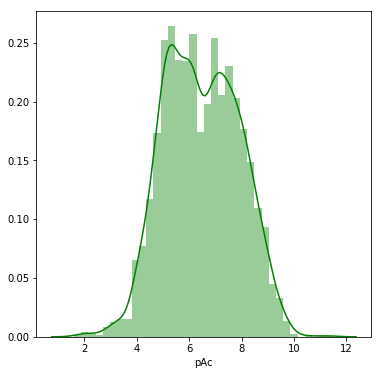

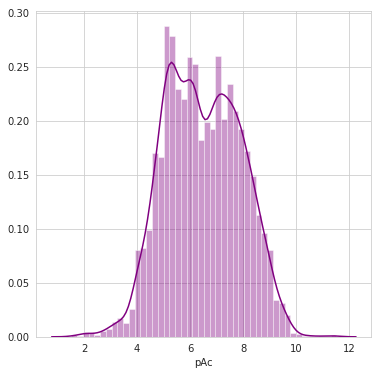

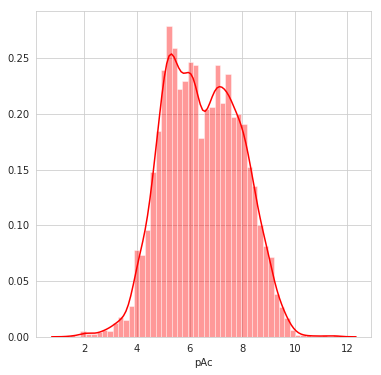

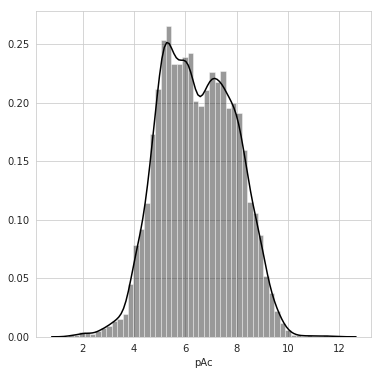

In [32]:

#Plot distribution of the pAc before augmentation and after each augmentation with the density estimation function
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df0.pAc,color = 'green');
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df1.pAc,color = 'purple');
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df2.pAc,color = 'red');
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df3.pAc,color = 'black');
sns.set_style("whitegrid")

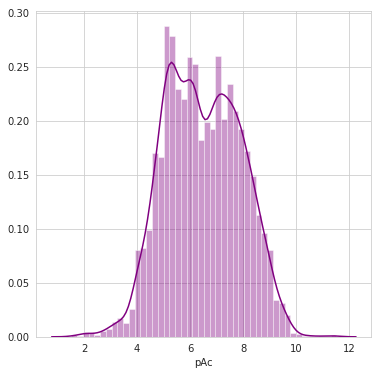

In [33]:

#Plot distribution of the pAc with the density estimation function after scaling
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df1.pAc,color = 'purple');
sns.set_style("whitegrid")

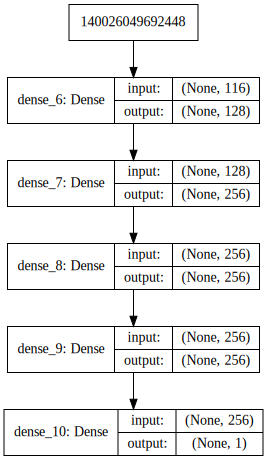

In [34]:

# Visualize network architecture
SVG(model_to_dot(model1, show_shapes=True).create(prog='dot', format='svg'))

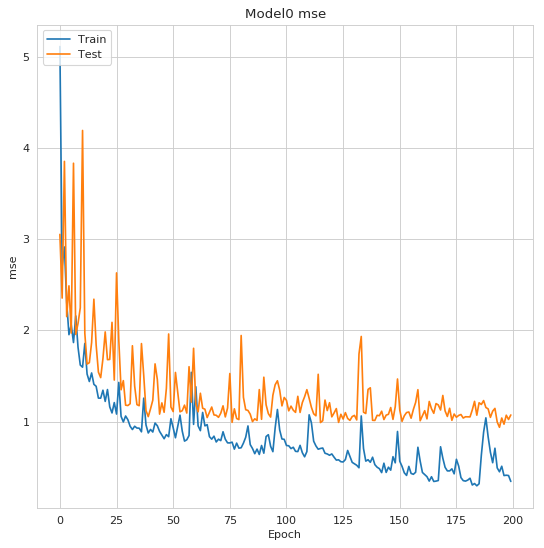

In [35]:
# Plot training mse for model0
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(history0.history['mean_squared_error'])
plt.plot(history0.history['val_mean_squared_error'])
plt.title('Model0 mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

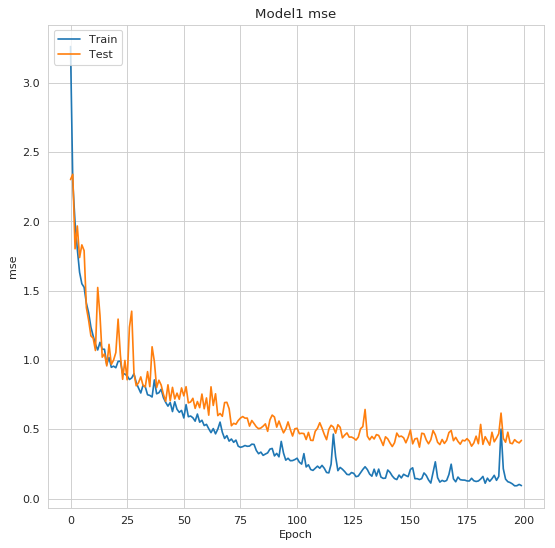

In [36]:
# Plot model1 training error for model 1
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(history1.history['mean_squared_error'])
plt.plot(history1.history['val_mean_squared_error'])
plt.title('Model1 mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


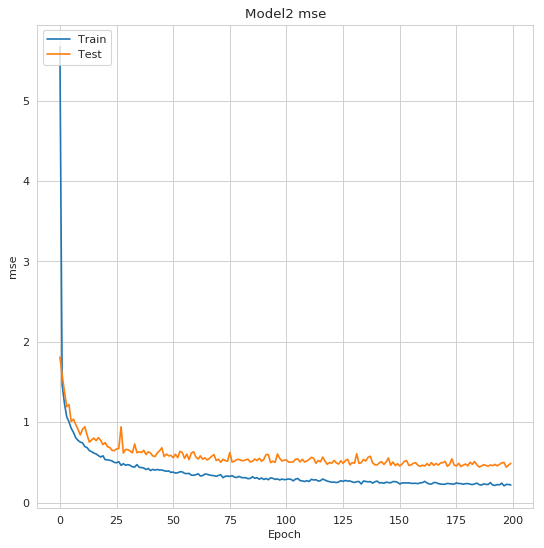

In [37]:
# Plot training mse for model 2
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(history2.history['mean_squared_error'])
plt.plot(history2.history['val_mean_squared_error'])
plt.title('Model2 mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

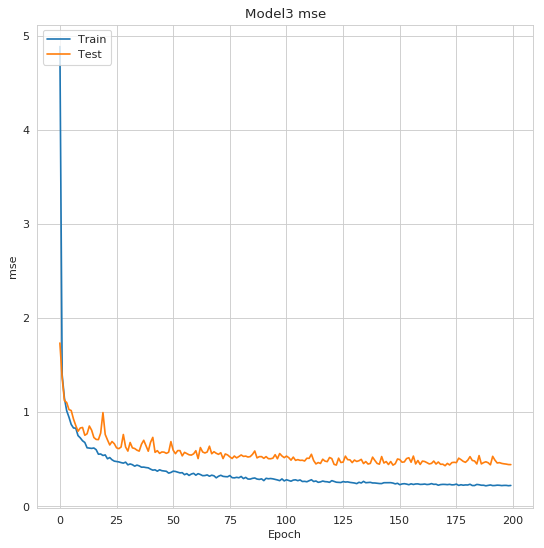

In [38]:
# Plot training mse for model 3
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(history3.history['mean_squared_error'])
plt.plot(history3.history['val_mean_squared_error'])
plt.title('Model3 mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

VISUALIZE MODEL0 PREDICTION

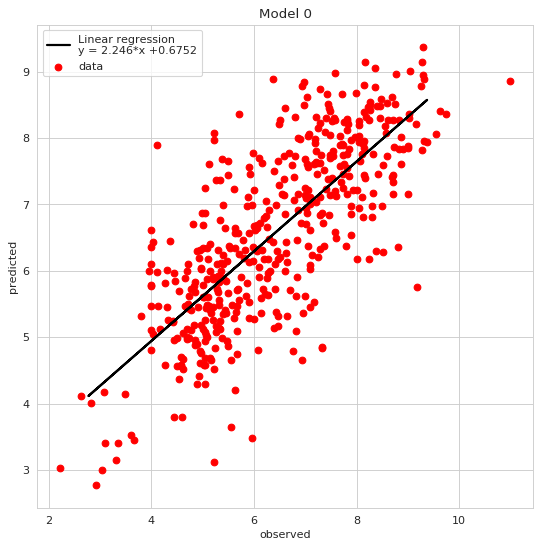

In [39]:

# Plot a regression line against model0 predictions on validation set
regressor = LinearRegression()  
regressor.fit(y_test_val.reshape(-1,1), valid_pred0)  
y_fit = regressor.predict(valid_pred0) 

reg_intercept = round(regressor.intercept_[0],4)
reg_coef = round(regressor.coef_.flatten()[0],4)
reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_test_val, valid_pred0, color='red', label= 'data')
plt.plot(valid_pred0, y_fit, color='black', linewidth=2, label = 'Linear regression\n'+reg_label) 
plt.title('Model 0')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

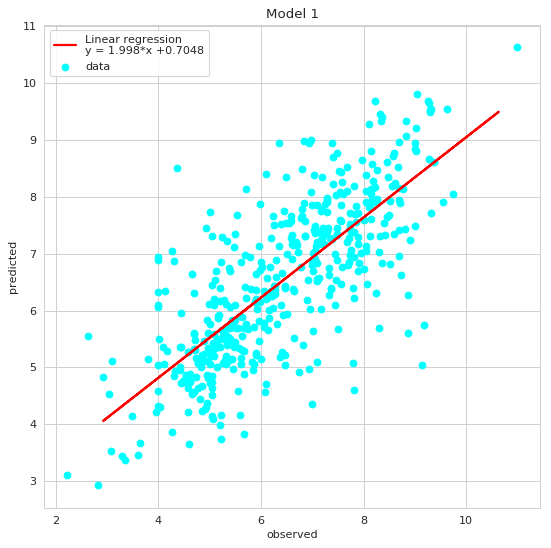

In [40]:
#Plot a regression line against model1 predictions on validation set
  regressor.fit(y_test_val.reshape(-1,1), valid_pred1)  
y_fit = regressor.predict(valid_pred1) 

reg_intercept = round(regressor.intercept_[0],4)
reg_coef = round(regressor.coef_.flatten()[0],4)
reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_test_val, valid_pred1, color='aqua', label= 'data')
plt.plot(valid_pred1, y_fit, color='red', linewidth=2, label = 'Linear regression\n'+reg_label) 
plt.title('Model 1')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

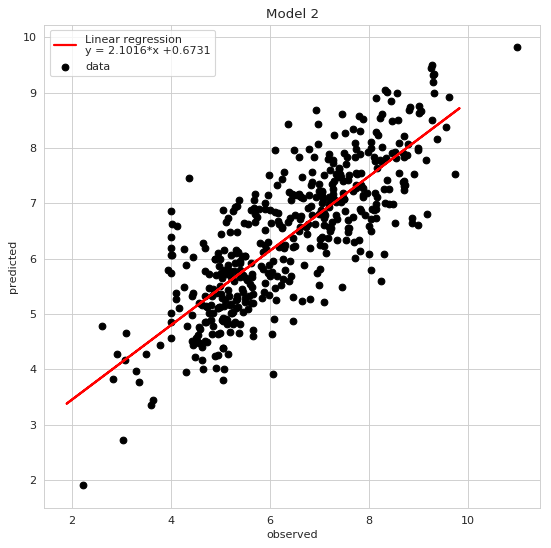

In [41]:
# print the linear regression and display datapoints
  regressor.fit(y_test_val.reshape(-1,1), valid_pred2)  
y_fit = regressor.predict(valid_pred2) 

reg_intercept = round(regressor.intercept_[0],4)
reg_coef = round(regressor.coef_.flatten()[0],4)
reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_test_val, valid_pred2, color='black', label= 'data')
plt.plot(valid_pred2, y_fit, color='red', linewidth=2, label = 'Linear regression\n'+reg_label) 
plt.title('Model 2')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

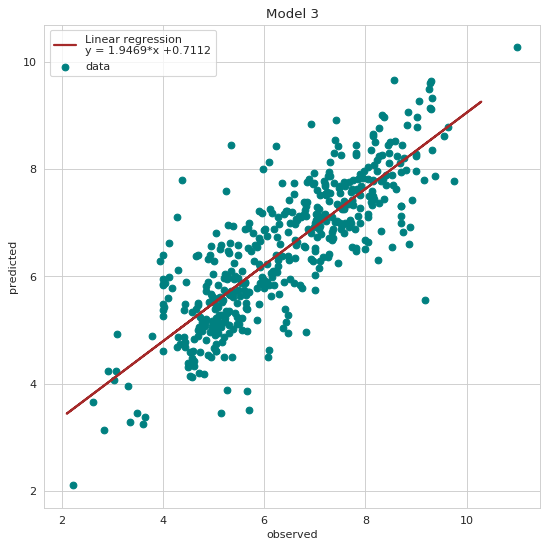

In [42]:
# print the linear regression and display datapoints  
regressor.fit(y_test_val.reshape(-1,1), valid_pred3)  
y_fit = regressor.predict(valid_pred3) 

reg_intercept = round(regressor.intercept_[0],4)
reg_coef = round(regressor.coef_.flatten()[0],4)
reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_test_val, valid_pred3, color='teal', label= 'data')
plt.plot(valid_pred3, y_fit, color='brown', linewidth=2, label = 'Linear regression\n'+reg_label) 
plt.title('Model 3')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()